# Baseline Model Experiment 

In [ ]:
import sys; sys.executable

## Imports 

In [2]:
from fastai.tabular import *
from fastai.metrics import *
from fastai import torch_core
from fastai.callbacks import *
from fastai.callbacks.mem import PeakMemMetric
from fastai.utils.mod_display import *

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src import data

import torch

## Read Data

This experiment uses data from the Hawaii dataset. We train on days 300 and 301 and predict on days 302 (day of earthquake), 303, and 304. 




In [3]:
year = 2012
location = "hawaii"

doys = [300, 301, 302, 303, 304]
dataframes = dict()

for d in doys:
    print("\n--- " + str(d) + "---")
    
    # read in the data 
    df = data.read_day(
        location=location,
        year=year,
        day_of_year=d
    )
    dataframes[d] = df

  0%|          | 4/1595 [00:00<00:54, 29.33it/s]


--- 300---
Reading dataframes...


100%|██████████| 1595/1595 [00:43<00:00, 36.58it/s]


Concatenating dataframes...


  0%|          | 4/1596 [00:00<00:39, 39.87it/s]


--- 301---
Reading dataframes...


100%|██████████| 1596/1596 [00:41<00:00, 38.24it/s]


Concatenating dataframes...


  0%|          | 4/1597 [00:00<00:39, 39.83it/s]


--- 302---
Reading dataframes...


100%|██████████| 1597/1597 [00:43<00:00, 36.31it/s]


Concatenating dataframes...


  0%|          | 4/1597 [00:00<00:40, 39.48it/s]


--- 303---
Reading dataframes...


100%|██████████| 1597/1597 [00:43<00:00, 36.67it/s]


Concatenating dataframes...


  0%|          | 4/1596 [00:00<00:41, 38.13it/s]


--- 304---
Reading dataframes...


100%|██████████| 1596/1596 [00:43<00:00, 36.59it/s]


Concatenating dataframes...


In [4]:
# concatenate the dataframes loaded previously into one large dataframe 
df_all = pd.concat([dataframes[d] for d in dataframes.keys()]) 

## Experimental Parameter Definitions

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.cuda.device_count()

4

In [7]:
torch.cuda.set_device(3)

In [8]:
torch.cuda.current_device()

3

In [9]:
cuda_device = torch.device('cuda:3')

One useful command for monitoring GPU utilization is one from `nvidia-smi`:

```bash
nvidia-smi -q -g 0 -d UTILIZATION -l
```

In [10]:
TIME_AGG = "1Min" # 5T, 20T, 60T
# SATS = ["G04", "G07", "G08", "G10", "G13", "G20", "G23"]
# FEATURES = []

## Prep Dataset

In [11]:
df_time_agg = df_all.resample(TIME_AGG).mean()

In [12]:
#only obtaining the plots for ahup_G10,20, 13, 23, 4, 7, 8 according to previous work 
df_sat = pd.concat(
    [df_time_agg.filter(regex='ahup__G[0][478]', axis=1), 
     df_time_agg.filter(regex='ahup__G[1][03]', axis=1), 
     df_time_agg.filter(regex='ahup__G[2][03]', axis=1)], 
    axis=1
)

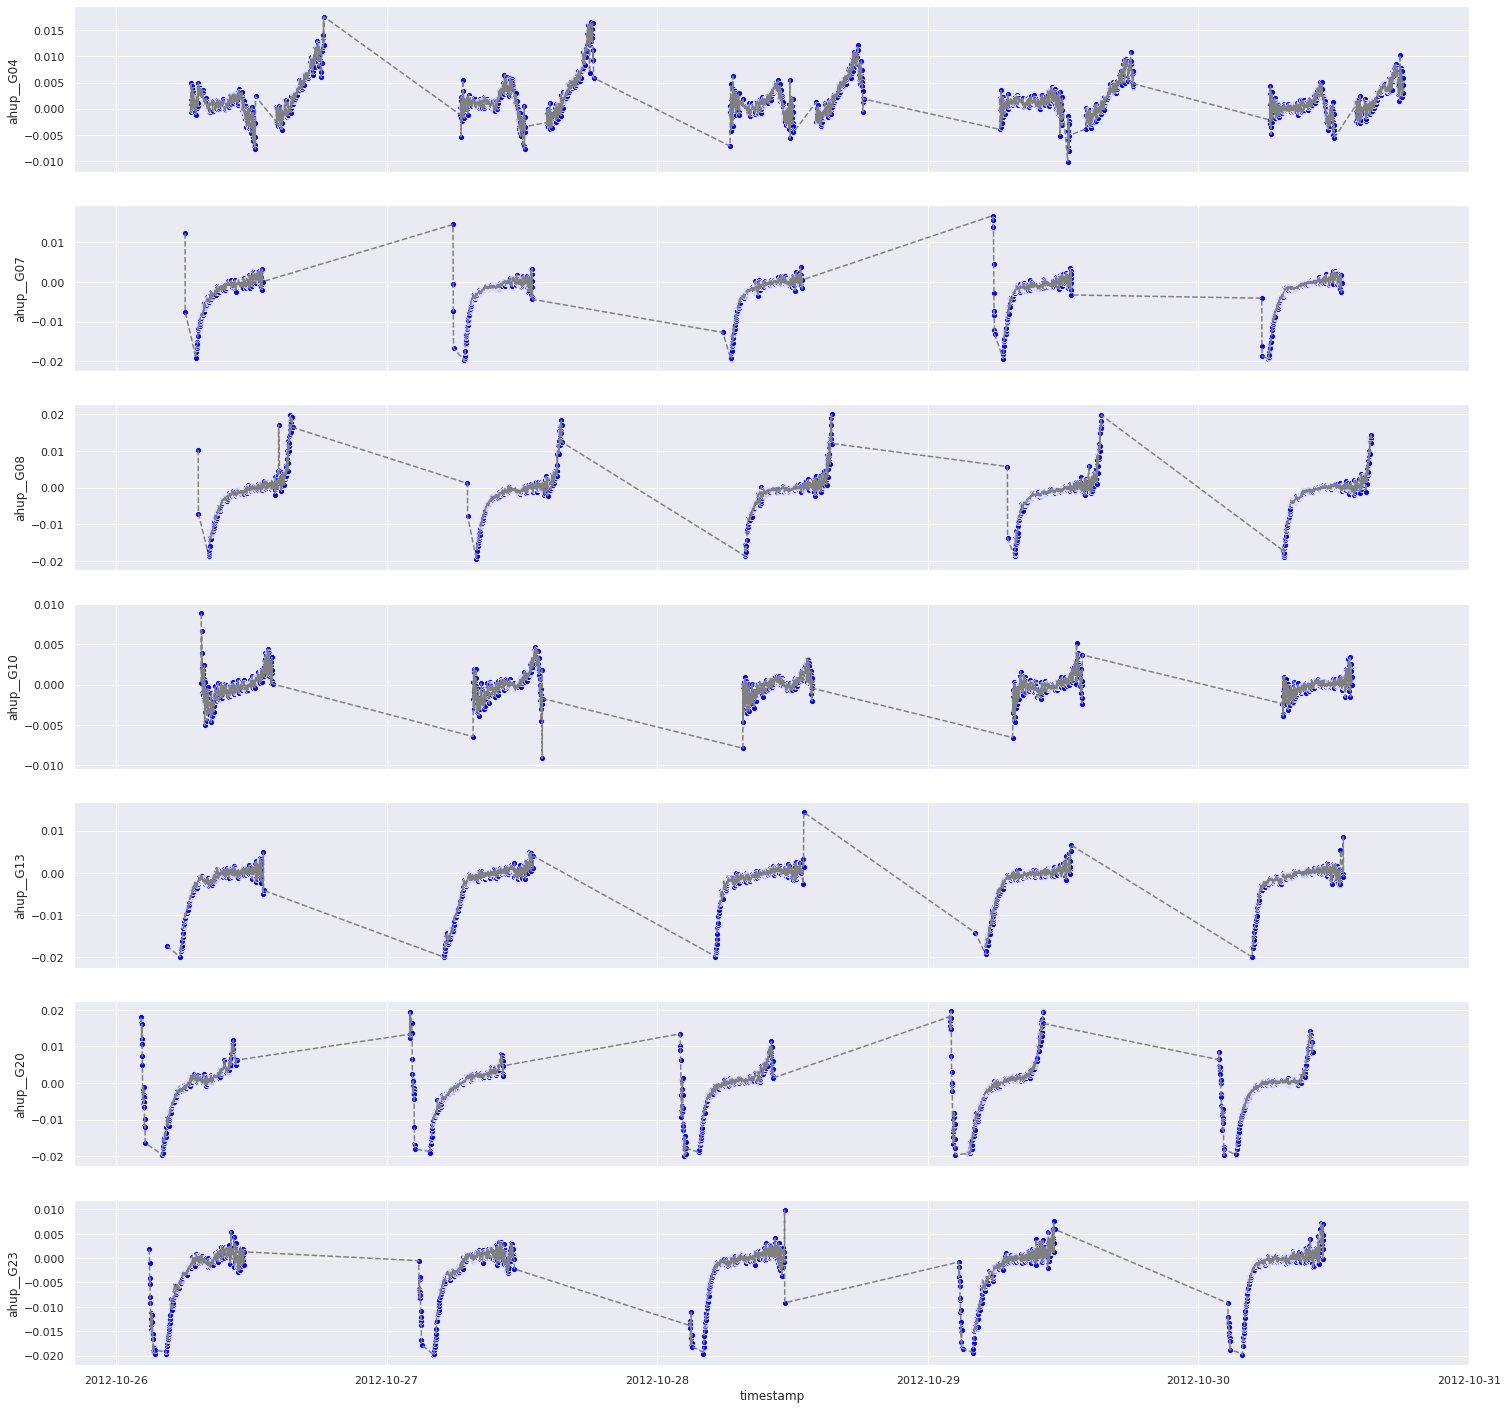

In [13]:
# ecreate subplots similar to the paper
sats = list()
for sat in df_sat:
    if "lat" not in sat and "lon" not in sat and "ele" not in sat and "azi" not in sat and "ipp" not in sat:
        sats.append(sat)


sns.set(style="darkgrid")
f, axes = plt.subplots(len(sats), 1, figsize=(25,25), sharex=True)
i = 0

for sat in sats:
    ax = sns.lineplot(x=df_sat.index, y=sat, ax=axes[i], data=df_sat, color="gray")
    ax.lines[0].set_linestyle("--")
    
    ax2 = sns.scatterplot(x=df_sat.index, y=sat,
                data=df_sat, ax=axes[i],
                color="blue")
    
    i += 1


plt.show()

In [14]:
df_sat.columns.values

array(['ahup__G04', 'ahup__G04_lon', 'ahup__G04_lat', 'ahup__G04_h_ipp', 'ahup__G04_ele', 'ahup__G04_azi', 'ahup__G07',
       'ahup__G07_lon', 'ahup__G07_lat', 'ahup__G07_h_ipp', 'ahup__G07_ele', 'ahup__G07_azi', 'ahup__G08',
       'ahup__G08_lon', 'ahup__G08_lat', 'ahup__G08_h_ipp', 'ahup__G08_ele', 'ahup__G08_azi', 'ahup__G10',
       'ahup__G10_lon', 'ahup__G10_lat', 'ahup__G10_h_ipp', 'ahup__G10_ele', 'ahup__G10_azi', 'ahup__G13',
       'ahup__G13_lon', 'ahup__G13_lat', 'ahup__G13_h_ipp', 'ahup__G13_ele', 'ahup__G13_azi', 'ahup__G20',
       'ahup__G20_lon', 'ahup__G20_lat', 'ahup__G20_h_ipp', 'ahup__G20_ele', 'ahup__G20_azi', 'ahup__G23',
       'ahup__G23_lon', 'ahup__G23_lat', 'ahup__G23_h_ipp', 'ahup__G23_ele', 'ahup__G23_azi'], dtype=object)

In [15]:
df_sat.head()

,ahup__G04,ahup__G04_lon,ahup__G04_lat,ahup__G04_h_ipp,ahup__G04_ele,ahup__G04_azi,ahup__G07,ahup__G07_lon,ahup__G07_lat,ahup__G07_h_ipp,...,ahup__G20_lat,ahup__G20_h_ipp,ahup__G20_ele,ahup__G20_azi,ahup__G23,ahup__G23_lon,ahup__G23_lat,ahup__G23_h_ipp,ahup__G23_ele,ahup__G23_azi
timestamp,,,,,,,,,,,,,,,,,,,,,
2012-10-26 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-26 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-26 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-26 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-26 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# get those dates from the 28th of the month, day of the earthquake
filter_index = df_sat.index.to_series().between('2012-10-28', '2012-10-28 23:59:00')

In [17]:
df_sat_earthquake = df_sat[filter_index]

In [18]:
df_sat_earthquake

,ahup__G04,ahup__G04_lon,ahup__G04_lat,ahup__G04_h_ipp,ahup__G04_ele,ahup__G04_azi,ahup__G07,ahup__G07_lon,ahup__G07_lat,ahup__G07_h_ipp,...,ahup__G20_lat,ahup__G20_h_ipp,ahup__G20_ele,ahup__G20_azi,ahup__G23,ahup__G23_lon,ahup__G23_lat,ahup__G23_h_ipp,ahup__G23_ele,ahup__G23_azi
timestamp,,,,,,,,,,,,,,,,,,,,,
2012-10-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-28 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-28 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-28 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-28 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-10-28 23:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-28 23:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-28 23:57:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


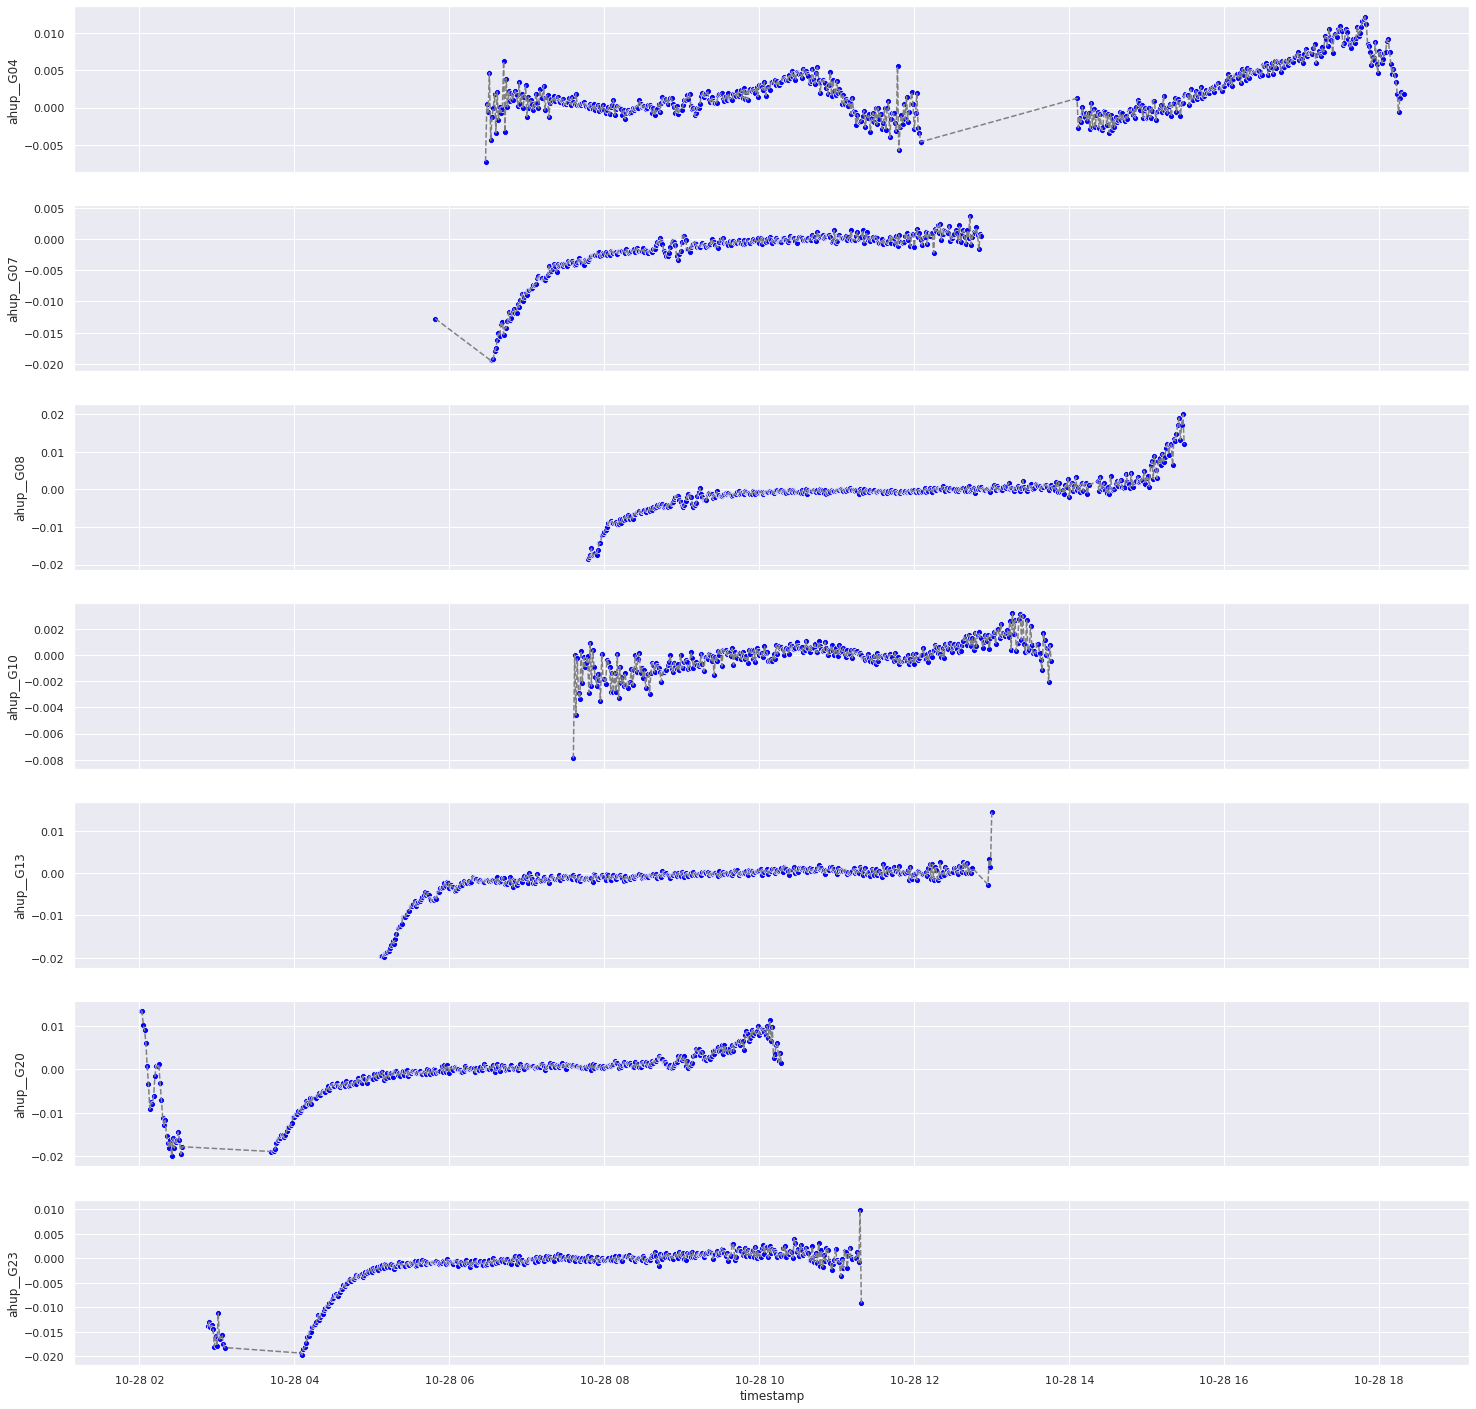

In [19]:
# ecreate subplots similar to the paper
sats = list()
for sat in df_sat_earthquake:
    if "lat" not in sat and "lon" not in sat and "ele" not in sat and "azi" not in sat and "ipp" not in sat:
        sats.append(sat)


sns.set(style="darkgrid")
f, axes = plt.subplots(len(sats), 1, figsize=(25,25), sharex=True)
i = 0

for sat in sats:
    ax = sns.lineplot(x=df_sat_earthquake.index, y=sat, ax=axes[i], data=df_sat_earthquake, color="gray")
    ax.lines[0].set_linestyle("--")
    
    ax2 = sns.scatterplot(x=df_sat_earthquake.index, y=sat,
                data=df_sat_earthquake, ax=axes[i],
                color="blue")
    
    i += 1


plt.show()

In [20]:
# handle missing values 


In [22]:
# rescale the data 
df_sat_normalized = data.rescale(df_sat.dropna())


/home/vconstan/projects/sTEC-d-dt-Anomaly-Detection/src/data.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[col] = minmax_scale(X=dataframe[col], feature_range=(minimum, maximum))


In [23]:
df_sat_normalized.shape

(742, 42)

In [24]:
train_start_index = 0
train_end_index = int(df_sat_normalized.shape[0] * 0.7)
test_start_index = train_end_index + 1
test_end_index = int(df_sat_normalized.shape[0] * 0.15) +  test_start_index
valid_start_index = test_end_index + 1
valid_end_index = df_sat_normalized.shape[0]

In [25]:
df_train = df_sat_normalized.iloc[train_start_index:train_end_index, :]
df_test = df_sat_normalized.iloc[test_start_index:test_end_index, :]
df_validation = df_sat_normalized.iloc[valid_start_index:valid_end_index, :]

In [26]:
df_train.columns.values

array(['ahup__G04', 'ahup__G04_lon', 'ahup__G04_lat', 'ahup__G04_h_ipp', 'ahup__G04_ele', 'ahup__G04_azi', 'ahup__G07',
       'ahup__G07_lon', 'ahup__G07_lat', 'ahup__G07_h_ipp', 'ahup__G07_ele', 'ahup__G07_azi', 'ahup__G08',
       'ahup__G08_lon', 'ahup__G08_lat', 'ahup__G08_h_ipp', 'ahup__G08_ele', 'ahup__G08_azi', 'ahup__G10',
       'ahup__G10_lon', 'ahup__G10_lat', 'ahup__G10_h_ipp', 'ahup__G10_ele', 'ahup__G10_azi', 'ahup__G13',
       'ahup__G13_lon', 'ahup__G13_lat', 'ahup__G13_h_ipp', 'ahup__G13_ele', 'ahup__G13_azi', 'ahup__G20',
       'ahup__G20_lon', 'ahup__G20_lat', 'ahup__G20_h_ipp', 'ahup__G20_ele', 'ahup__G20_azi', 'ahup__G23',
       'ahup__G23_lon', 'ahup__G23_lat', 'ahup__G23_h_ipp', 'ahup__G23_ele', 'ahup__G23_azi'], dtype=object)

In [27]:
FEATURES = [
    "ahup__G07",
#     "ahup__G04_ele"
]

In [28]:
DEP = "ahup__G07"
df_sat_normalized[DEP + "_target"] = df_sat[DEP]

/home/vconstan/.conda/envs/tsunami/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_sat_normalized

In [29]:
## Work in progress
def make_dataBunch(dataframe: 'pd.DataFrame', features: list, dependent: str, include_catvars: bool = False, catvars: list = [], batch_size: int = 256):
    """
    Takes a dataframe and splits it into 3 sequential blocks - 70% training, 
    15% validation, 15% testing. Creates a TabularDataBunch to feed as an input 
    into the learner. 
    """
    
#     # INAPPROPRIATE 
#     dataframe = dataframe.dropna()
        
    # get the indices for the dataframes
    train_start_index = 0
    train_end_index = int(dataframe.shape[0] * 0.4)
    valid_start_index = train_end_index + 1
    valid_end_index = int(dataframe.shape[0] * 0.4) +  valid_start_index
    test_start_index = valid_end_index + 1
    test_end_index = dataframe.shape[0]
        
    # create versions of the original dataframe for plotting and other purposes
    df_train = dataframe.iloc[train_start_index:train_end_index, :]
    df_validation = dataframe.iloc[valid_start_index:valid_end_index, :]
    df_train_validation = dataframe.iloc[train_start_index:valid_end_index, :]
    df_test = dataframe.iloc[test_start_index:test_end_index, :]
    
    print(df_train.shape)
    print(df_test.shape)
    print(df_validation.shape)
    
    # create the data bunch
    if include_catvars:
        data = TabularDataBunch.from_df(
            "models", 
            df_train_validation[features + [dependent]], 
            dependent, 
            valid_idx=np.array(list(range(valid_start_index, valid_end_index))),
            test_df=df_test, 
            procs=[Categorify],
            bs=batch_size, # batch size
            cat_names=catvars,
            device=cuda_device,
            num_workers=0
        )
    else:
        data = TabularDataBunch.from_df(
            "models", 
            df_train_validation[features + [dependent]], 
            dependent, 
            valid_idx=np.array(list(range(valid_start_index, valid_end_index))),
            test_df=df_test, 
            procs=None, # disable any automatic preprocessing
            bs=batch_size, # batch size
            device=cuda_device,
            num_workers=0
        )
 
    return {"databunch": data, "train": df_train, "valid": df_validation, "test": df_test}

In [30]:
BATCH_SIZE = 8

In [31]:
# cat_names = [col for col in features if "t-" in col]
model_data = make_dataBunch(
    df_sat_normalized, 
    FEATURES, 
    DEP + "_target", 
    include_catvars=False, 
    catvars=None, 
    batch_size=BATCH_SIZE
)

(296, 43)
(148, 43)
(296, 43)


In [32]:
model_data["databunch"].show_batch()

ahup__G07_target,ahup__G07,target
-0.0027,0.4114,-0.0026931071
-0.0015,0.6219,-0.001523897
-0.0011,0.6938,-0.001124434
-0.0009,0.7364,-0.00088797533
-0.0015,0.6319,-0.0014685554


## Learning

In [38]:
lr = tabular_learner(
    model_data["databunch"], 
    layers=[10, 10], 
#     ps=[0.0, 0.1, 0.2, 0.1, 0.0],
    metrics=[root_mean_squared_error], 
    callback_fns=[CSVLogger, PeakMemMetric]
)

In [39]:
# # CPU only 
# lr.model = lr.model.cpu()

### Determine the Learning Rate

We utilize an [automatic learning rate finder](https://forums.fast.ai/t/automated-learning-rate-suggester/44199/8) to determine the ideal learning rate automatically. While this approach does not always guarantee that the perfect learning rate is found, in practice we have found the approach to work well and has been quite stable.

In [40]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find(
        end_lr=2.,
        stop_div=False # continues through all LRs as opposed to auto stopping
    )
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


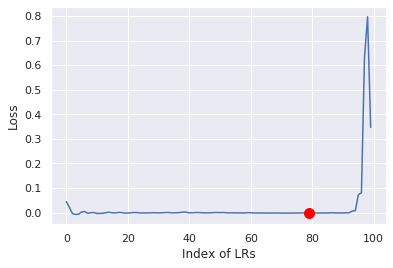

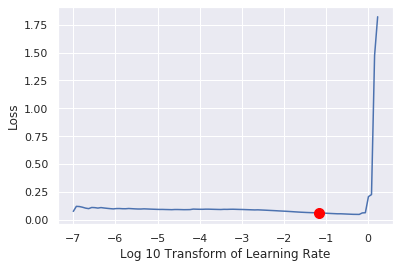

In [41]:
learn_rate = find_appropriate_lr(
    model=lr,
    plot=True
)

### Train the Model

Early stopping is used to avoid model overfitting, and save the model on each training cycle. The `%%monitor_cell` monitor cell command is used for Hyperdash, which allows for tracking model training progress.

epoch,train_loss,valid_loss,root_mean_squared_error,cpu used,peak,gpu used,peak,time
0,0.021070,0.001510,0.037680,0,0,0,0,00:00
1,0.009617,0.005682,0.066155,0,0,0,0,00:00
2,0.005051,0.000497,0.021424,0,0,0,0,00:00
3,0.002515,0.000218,0.013431,0,0,0,0,00:00
4,0.001411,0.000146,0.011416,0,0,0,0,00:00
5,0.000711,0.000096,0.008879,0,0,0,0,00:00
6,0.000363,0.000082,0.008342,0,0,0,0,00:00
7,0.000389,0.000738,0.012963,0,0,0,0,00:00
8,0.000240,0.000044,0.006263,0,0,0,0,00:00
9,0.000136,0.000069,0.008019,0,0,0,0,00:00


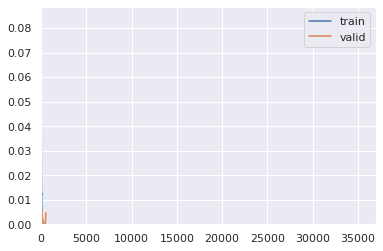

Epoch 13: early stopping


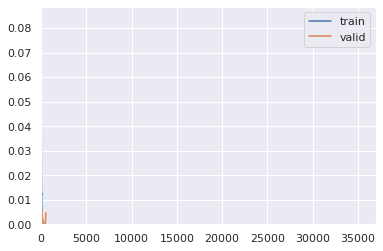

In [42]:
# from hyperdash import monitor_cell
# %%monitor_cell "Magnetosphere State Model Training"

lr.fit_one_cycle(
    1000, # fit bad model for now while we build out everything
    learn_rate,
    callbacks=[
        SaveModelCallback(
            lr, 
            every='epoch', 
            monitor=['accuracy']
        ),
        EarlyStoppingCallback(
            lr,
            monitor='valid_loss',
            min_delta=0.001, 
            patience=10
        ),
        ShowGraph(
            lr
        )
        
        # overfit monitor callback? 
        # if spread between train and valid loss is too high
        # then stop training due to overfitting 
        
    ]
)